In [1]:
import os
Root = "/content/drive/MyDrive/GTSR"
os.chdir(Root)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [4]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt 
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(870383)

from matplotlib import style
style.use('fivethirtyeight')

Set the directory and the image dimentions and channels, we have 3 channels since we have an RGB colour

In [5]:
data_dir = "/content/drive/MyDrive/GTSR"
train_path = 'Train'
test_path = 'Test'

IMG_HEIGHT = 30
IMG_WIDTH = 30
channels =3 

Find the number of total classes. To do so we go inside the Train folder inside the Google Drive and we take the list of the folders that go from 0 to 42 and we do the len so we have 43 in the end

In [6]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

We build the classes, one for each sign 

In [7]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

I print each category and see what is the number of examples for each category


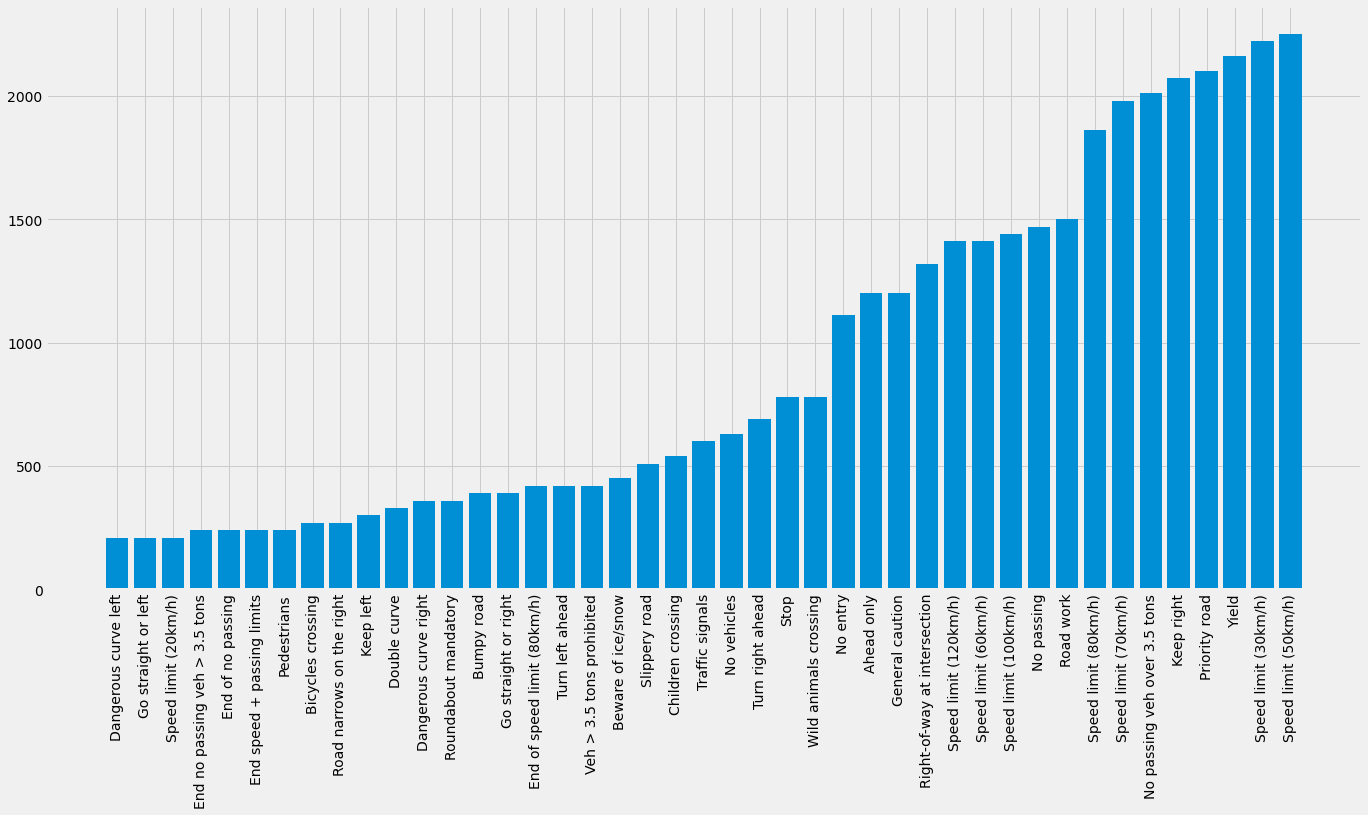

In [8]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

 Visualizing 25 random images from test data

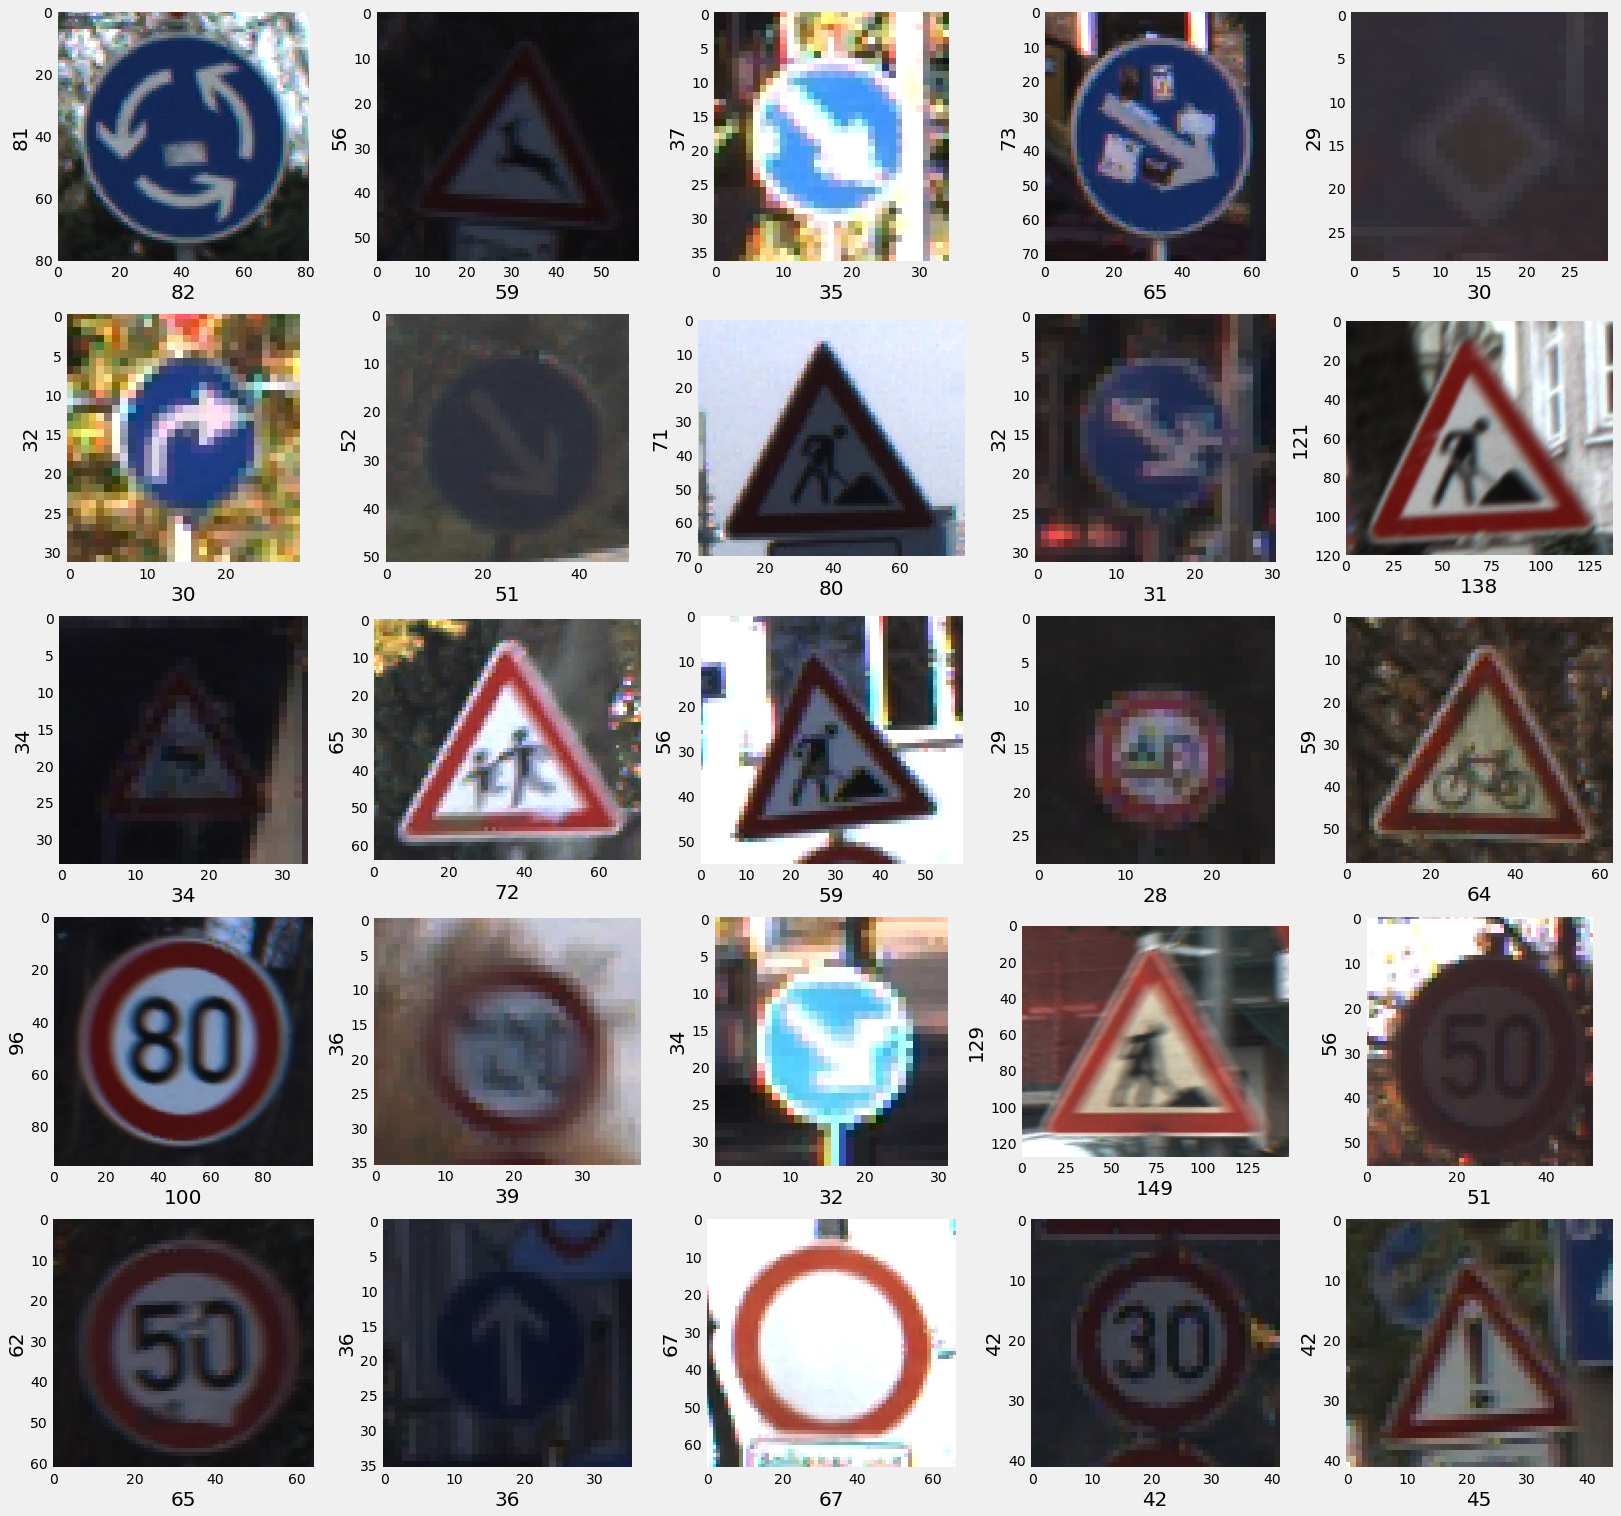

In [9]:

import random
from matplotlib.image import imread

test = pd.read_csv('/content/drive/MyDrive/GTSR/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)

    #taking the data from the directory randomly
    random_img_path = data_dir + '/' + random.choice(imgs)
    #once we take the random image path than we basically try to read the image in order to be able to plot it
    rand_img = imread(random_img_path)
    #plot the image
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

Here we try to collect the training data

In [10]:
image_data = []     #image data list
image_labels = []   #image label list

for i in range(NUM_CATEGORIES):  #number of the categories is 43 as we calculated before
    path = data_dir + '/Train/' + str(i)  #the path of all the images in the training folder we do it for each folder
                                          #one at the time
    images = os.listdir(path) 

    for img in images:
        try:
            #we take the image
            image = cv2.imread(path + '/' + img)       
            #we convert it into an array -> find out why
            image_fromarray = Image.fromarray(image, 'RGB')
            #resize the image in the 30 by 30 size
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            #once I resized it I will convert it into an array and append it to the image data and than to the label
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


Shuffling the training data.
If we are about to make a train/test split and the data were sorted by category beforehand, we might end up training on just half of the classes. That would be bad. Uniform shuffle guarantees that every item has the same chance to occur at any position

In [11]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

Split the data into train and validation . Ratio is 70 - 30 

In [12]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

#Rescaling because  if there is a vast difference in the range say few ranging in thousands and 
#few ranging in the tens,and it makes the underlying assumption that higher ranging numbers have superiority of some sort.
X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


One hot encoding the labels

In [13]:
from tensorflow.python import keras
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


In [14]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [15]:
lr = 0.001    #learning rate
epochs = 30

opt = Adam(lr=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

We are doing some data augmentation. and we train the model, this will help reduce the overfitting

In [16]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

#The batch size defines the number of samples that will be propagated through the network.
history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30
858/858 [==============================] - 96s 112ms/step - loss: 1.0696 - acc: 0.7111 - val_loss: 0.1636 - val_acc: 0.9494
Epoch 2/30
858/858 [==============================] - 94s 110ms/step - loss: 0.1754 - acc: 0.9461 - val_loss: 0.0515 - val_acc: 0.9844
Epoch 3/30
858/858 [==============================] - 94s 109ms/step - loss: 0.1142 - acc: 0.9652 - val_loss: 0.0172 - val_acc: 0.9952
Epoch 4/30
858/858 [==============================] - 94s 109ms/step - loss: 0.0778 - acc: 0.9757 - val_loss: 0.0115 - val_acc: 0.9958
Epoch 5/30
858/858 [==============================] - 94s 109ms/step - loss: 0.0661 - acc: 0.9796 - val_loss: 0.0164 - val_acc: 0.9946
Epoch 6/30
858/858 [==============================] - 94s 110ms/step - loss: 0.0615 - acc: 0.9805 - val_loss: 0.0159 - val_acc: 0.9956
Epoch 7/30
858/858 [==============================] - 95s 110ms/step - loss: 0.0502 - acc: 0.9839 - val_loss: 0.0078 - val_acc: 0.9980
Epoch 8/30
858/858 [==============================] - 9

In [17]:
model.save("model.h5")

In [18]:
model.save_weights("/content/drive/MyDrive/GTSR/output")

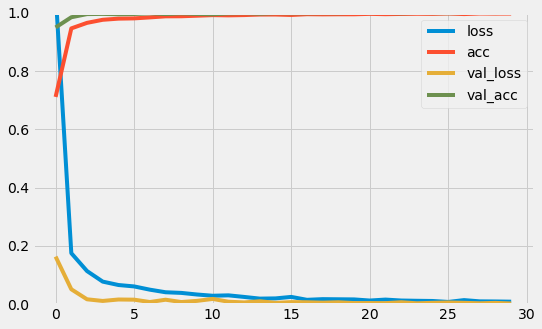

In [19]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [21]:


test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

pred = model.predict_classes(X_test)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

Test Data accuracy:  98.94695170229612


In [22]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)

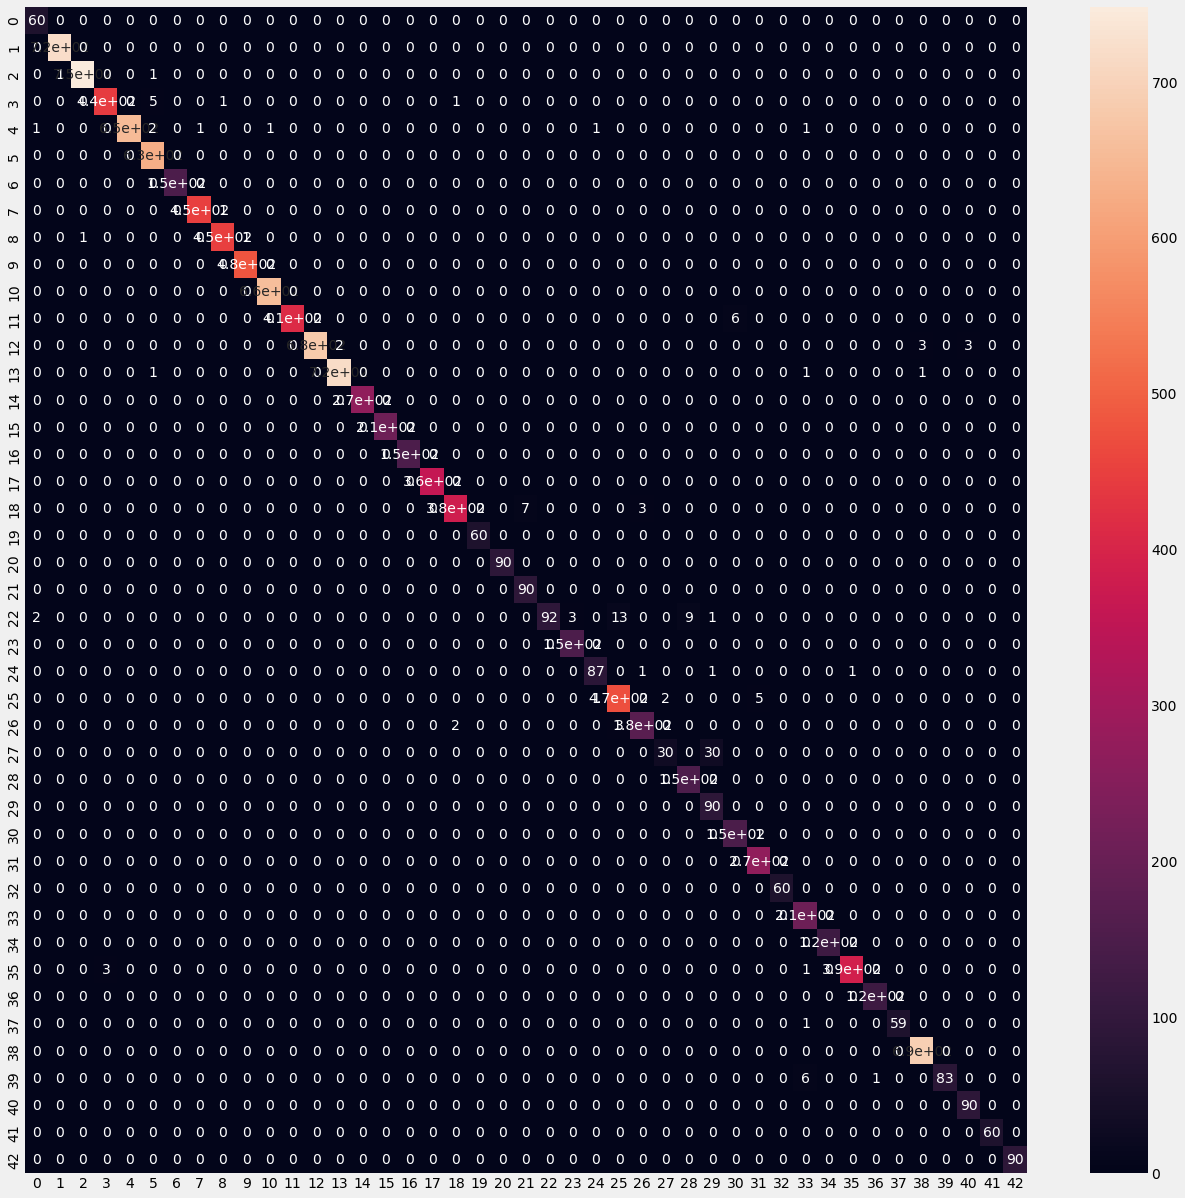

In [23]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

Doing some tests on the model.

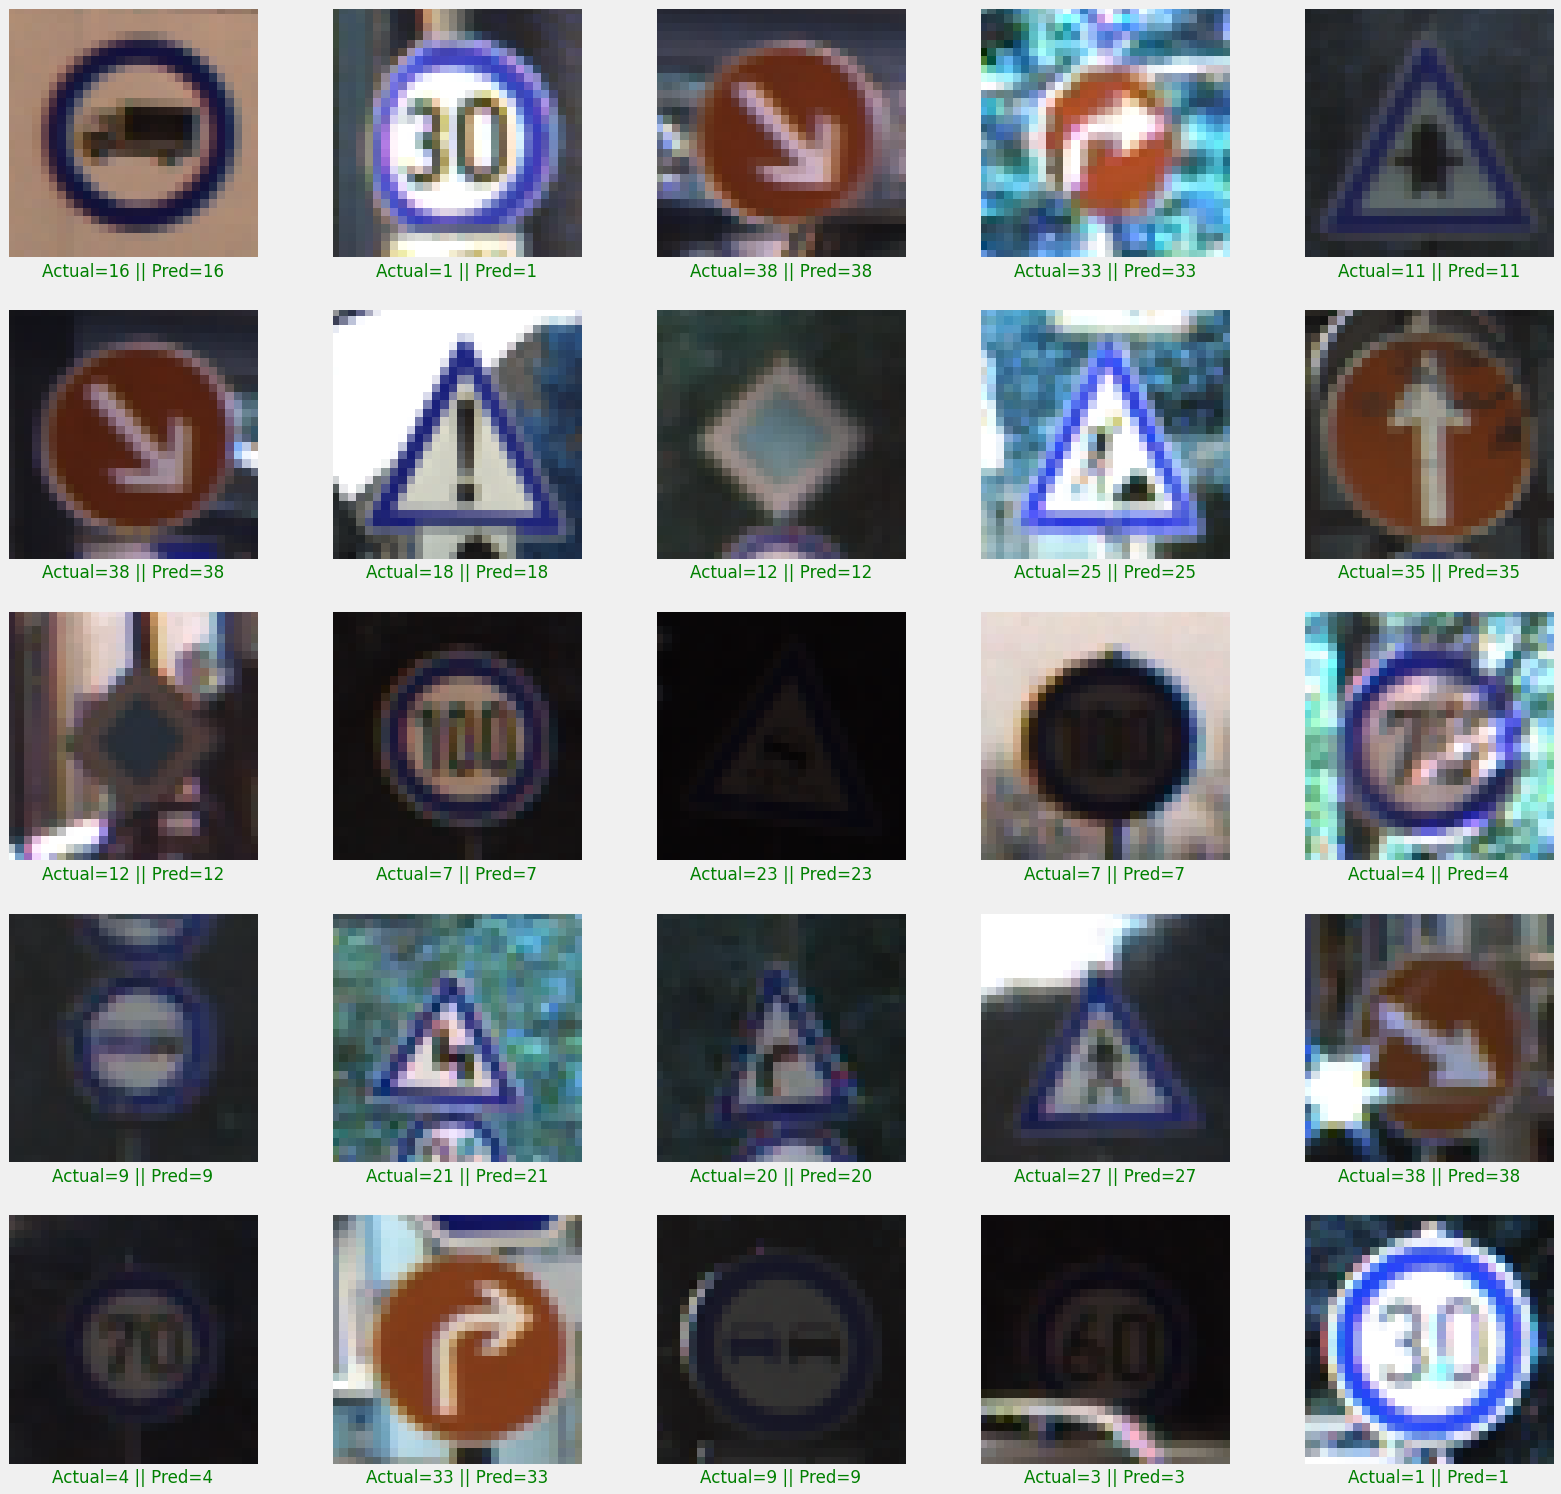

In [24]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

35

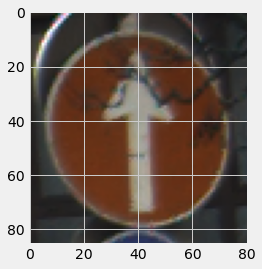

In [29]:
#model_path = "model.h5"
#loaded_model = tf.keras.models.load_model(model_path)

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

image = cv2.imread("/content/drive/MyDrive/GTSR/Test/00009.png")

image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((30, 30))
expand_input = np.expand_dims(resize_image,axis=0)
input_data = np.array(expand_input)
input_data = input_data/255

pred = model.predict(input_data)
result = pred.argmax()
plt.imshow(image)
result